In [1]:
!pip install kachery_cloud spikeforest
!pip install "spikeinterface==0.99.1"
!pip install matplotlib ipympl ipywidgets
!pip install hdbscan
!pip install numba
!pip install spiketoolkit



In [2]:
%matplotlib widget


In [3]:
import numpy
#Assorted useful python packages
import os
import numpy as np
import tqdm as notebook
import matplotlib.pyplot as plt
from pprint import pprint
import json

import spikeinterface.full as si #all spikeinterface modules
import spikeinterface.extractors as se
import spiketoolkit as st
import kachery_cloud as kcl #cloud host for spikeforest datasets
import spikeforest as sf #forked version of spikeforest



In [4]:
current_dir = os.getcwd()

#Choose dataset
first_boyden_recording_sf = sf.load_spikeforest_recording(study_name='paired_boyden32c', recording_name='1103_1_1') #, uri='sha1://849e53560c9241c1206a82cfb8718880fc1c6038?paired-boyden-spikeforest-recordings.json')
first_boyden_sorting_sf = sf.load_spikeforest_sorting_output(study_name='paired_boyden32c', recording_name='1103_1_1', sorter_name='JRClust')

#Convert dataset to spikeinterface format
first_boyden_recording = first_boyden_recording_sf.get_recording_extractor()
first_boyden_sorting = first_boyden_sorting_sf.get_sorting_extractor()

print(f'{first_boyden_recording_sf.study_set_name}/{first_boyden_recording_sf.study_name}/{first_boyden_recording_sf.recording_name}')
print(f'{first_boyden_sorting_sf.study_name}/{first_boyden_sorting_sf.recording_name}/{first_boyden_sorting_sf.sorter_name}')

##Set output folder
output_folder_MS = os.path.join(current_dir, 'folder_MS_5')

PAIRED_BOYDEN/paired_boyden32c/1103_1_1
paired_boyden32c/1103_1_1/JRClust


In [5]:
# ## Apply filters
# recording_bp = st.preprocessing.bandpass_filter(first_boyden_recording, freq_min=300, freq_max=6000)
# recording_notch = st.preprocessing.notch_filter(first_boyden_recording, freq=1000, q=10)

In [6]:
# test_sorting = si.run_sorter(sorter_name='spykingcircus2', recording=first_boyden_recording, remove_existing_folder=True, output_folder=output_folder_MS)

In [9]:
import scipy.signal as signal

def bandpass_filter_data(data, freq_min, freq_max, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    low = freq_min / nyquist
    high = freq_max / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data, axis=0)
    return filtered_data

# Example for filtering data manually
sample_rate = first_boyden_recording.get_sampling_frequency()
raw_data = first_boyden_recording.get_traces()
filtered_data = bandpass_filter_data(raw_data, freq_min=300, freq_max=6000, sample_rate=sample_rate)


IndexError: tuple index out of range

<class 'numpy.ndarray'>


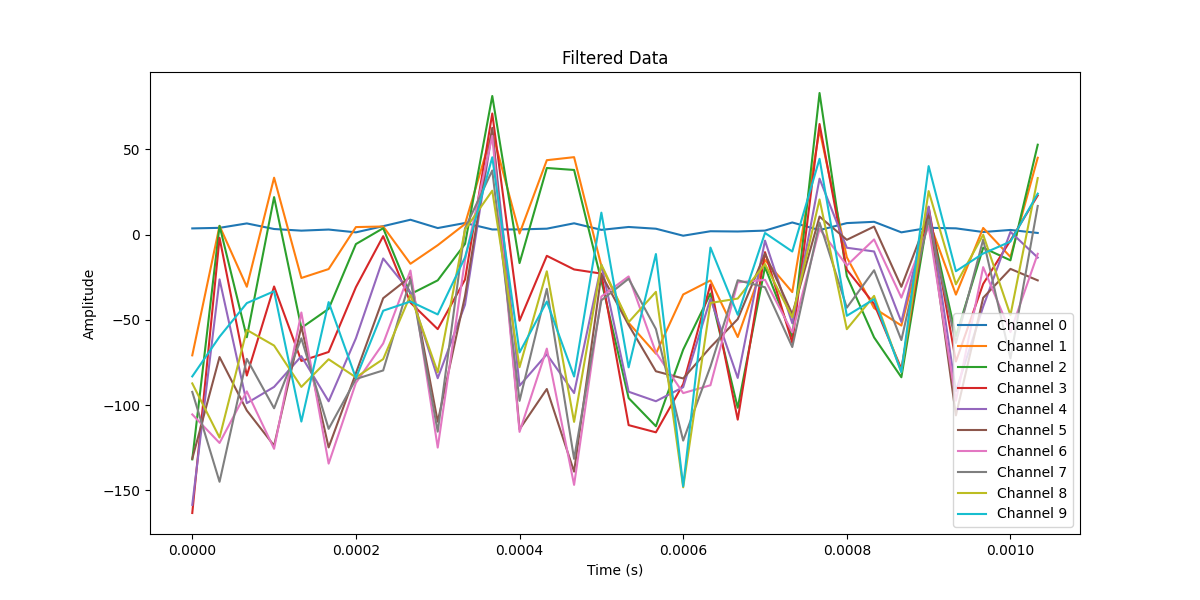

In [16]:
print(type(raw_data))

import numpy as np
import matplotlib.pyplot as plt

filtered_data = bandpass_filter_data(raw_data, freq_min=300, freq_max=6000, sample_rate=sample_rate)


# Assuming 'filtered_data' is a numpy array with shape (num_channels, num_samples)
# Replace this with your actual filtered_data variable
# filtered_data = np.random.randn(10, 10000)  # Example data with 10 channels and 10000 samples
sampling_frequency = 30000  # Example sampling frequency (Hz)

def plot_filtered_data(data, sampling_frequency, num_channels_to_plot=10):
    num_channels, num_samples = data.shape
    time = np.arange(num_samples) / sampling_frequency
    
    plt.figure(figsize=(12, 6))
    for i in range(min(num_channels, num_channels_to_plot)):  # Plot a subset of channels if needed
        plt.plot(time, data[i, :], label=f'Channel {i}')
    
    plt.title('Filtered Data')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Plot the filtered data


           

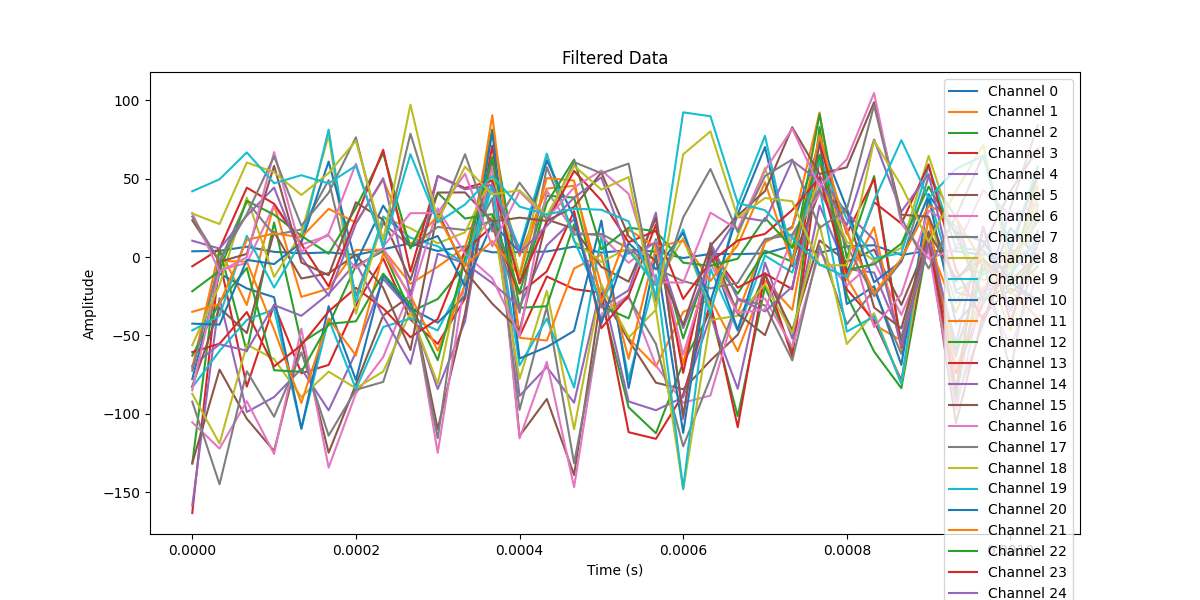

In [17]:
plot_filtered_data(filtered_data, sampling_frequency, num_channels_to_plot=30)


In [8]:
#matplotlib backend
si.set_default_plotter_backend(backend="ipywidgets")
print(si.get_default_plotter_backend())

from spikeinterface.preprocessing import common_reference

# ipywidgets backend also supports multiple "layers" for plot_traces
recording = first_boyden_recording
rec_dict = dict(filt=recording, cmr=common_reference(recording))
w = si.plot_traces(recording=rec_dict, backend="ipywidgets")
# w = si.plot_spikes_on_traces(recording=rec_dict, backend="ipywidgets")
# w = si.plot_spikes_on_traces(test_sorting, backend="ipywidgets")

ipywidgets


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [13]:
import spikeinterface as si
import spiketoolkit as st
import spikeforest as sf
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from spikeinterface.core import BaseRecording
from spikeinterface.preprocessing import common_reference
# import spikeinterface.plotting as spk_plot

# Load the recording from SpikeForest
first_boyden_recording_sf = sf.load_spikeforest_recording(study_name='paired_boyden32c', recording_name='1103_1_1')
first_boyden_recording = first_boyden_recording_sf.get_recording_extractor()

# Bandpass filter function
def bandpass_filter_data(data, freq_min, freq_max, sample_rate, order=4):
    nyquist = 0.5 * sample_rate
    low = freq_min / nyquist
    high = freq_max / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data, axis=0)
    return filtered_data

# Apply the bandpass filter to the raw data
sample_rate = first_boyden_recording.get_sampling_frequency()
raw_data = first_boyden_recording.get_traces()
filtered_data = bandpass_filter_data(raw_data, freq_min=300, freq_max=6000, sample_rate=sample_rate)



NameError: name 'BaseRecordingExtractor' is not defined

In [14]:

# Custom RecordingExtractor class to handle filtered data
class CustomRecordingExtractor(BaseRecording):
    def __init__(self, data, sampling_frequency, channel_names=None):
        super().__init__()
        self._data = data
        self._sampling_frequency = sampling_frequency
        self._n_channels, self._n_samples = data.shape
        self._channel_ids = np.arange(self._n_channels)
        self._channel_names = channel_names if channel_names is not None else [f'Channel {i}' for i in self._channel_ids]

    def get_num_channels(self):
        return self._n_channels

    def get_num_frames(self):
        return self._n_samples

    def get_traces(self, start_frame=0, end_frame=None, channel_ids=None):
        if end_frame is None:
            end_frame = self._n_samples
        if channel_ids is None:
            channel_ids = self._channel_ids
        return self._data[channel_ids, start_frame:end_frame]

    def get_channel_ids(self):
        return self._channel_ids

    def get_channel_names(self):
        return self._channel_names

    def get_sampling_frequency(self):
        return self._sampling_frequency

# Wrap the filtered data into the custom extractor
channel_names = [f'Channel {i}' for i in range(filtered_data.shape[0])]
custom_recording = CustomRecordingExtractor(filtered_data, sampling_frequency, channel_names)

# Verify the type of the custom recording
print("Custom recording type:", type(custom_recording))

# Visualization using SpikeInterface's built-in plotting functions
si.set_default_plotter_backend(backend="ipywidgets")
print("Using backend:", si.get_default_plotter_backend())

# Create a dictionary with the filtered recording
rec_dict = dict(filt=custom_recording, cmr=common_reference(custom_recording))

# # Plot traces with SpikeInterface's plotting functions
# w = spk_plot.plot_traces(recording=rec_dict, backend="ipywidgets")

# # Optional: For manual plotting using matplotlib
# def plot_filtered_data(recording):
#     num_channels = recording.get_num_channels()
#     data = recording.get_traces()

#     plt.figure(figsize=(12, 6))
#     for i in range(min(10, num_channels)):  # Plot the first 10 channels or fewer if fewer channels are present
#         plt.plot(data[i, :], label=f'Channel {i}')

#     plt.title('Filtered Traces')
#     plt.xlabel('Sample Index')
#     plt.ylabel('Amplitude')
#     plt.legend()
#     plt.show()

# # Plot using matplotlib
# plot_filtered_data(custom_recording)

NameError: name 'sampling_frequency' is not defined

In [ ]:
w = si.plot_traces(recording=rec_dict, backend="ipywidgets")
